# Youtube comments spam classification

This dataset is comprise of comments collection from users for videos on youtube of artist i.e Psy, Katy Perry, LMFAO, Eminem, and Shakira.

In these datasets, there is a class column where (0) indicates that it is not a spam and (1) if it is a Spam.

We will use this to build models which classify the comment is either a spam or not.


In [17]:
#pip install emoji

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from collections import Counter
from wordcloud import WordCloud
import nltk
import html
import re
import string
import emoji

In [19]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


False

## Importing dataset
First off we will be importing the datasets using the pandas library. the dataset from each csv file is merged into a variable called frames. ignore_index which is False in default is set to True so the resulting index will be written 0,1..n-1

In [20]:
df1 = pd.read_csv('Youtube01-Psy.csv')
df2 = pd.read_csv('Youtube02-KatyPerry.csv')
df3 = pd.read_csv('Youtube03-LMFAO.csv')
df4 = pd.read_csv('Youtube04-Eminem.csv')
df5 = pd.read_csv('Youtube05-Shakira.csv')

frames = [df1,df2,df3,df4,df5]
df = pd.concat(frames, ignore_index=True)
df.to_csv("not_clean.csv")

Here we can see what the columns of the datasets comprise of :

In [21]:
print(df.shape)
print(df.columns)
df.head

(1956, 5)
Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS'], dtype='object')


<bound method NDFrame.head of                                        COMMENT_ID                AUTHOR  \
0     LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU             Julius NM   
1     LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A           adam riyati   
2     LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8      Evgeny Murashkin   
3             z13jhp0bxqncu512g22wvzkasxmvvzjaz04       ElNino Melendez   
4             z13fwbwp1oujthgqj04chlngpvzmtt3r3dw                GsMega   
...                                           ...                   ...   
1951  _2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA          Katie Mettam   
1952  _2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI  Sabina Pearson-Smith   
1953  _2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs         jeffrey jules   
1954  _2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0        Aishlin Maciel   
1955  _2viQ_Qnc685RPw1aSa1tfrIuHXRvAQ2rPT9R06KTqA           Latin Bosch   

                            DATE  \
0            2013-11-07T06:20:48 

## Exploratory data analysis.
Distribution by label: Spam count is slightly more than spam altho not significant.

Text(0.5, 1.0, 'Frequency of Ham(0) & Spam(1)')

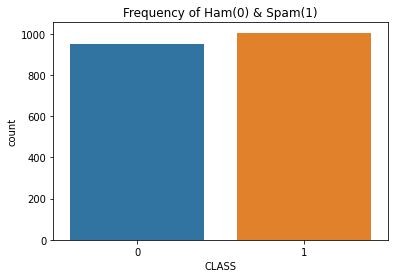

In [22]:
sb.countplot(x='CLASS',data=df).set_title("Frequency of Ham(0) & Spam(1)")

Now we can explore the average length of a spam or a ham. I start by counting the length ("comment_len") to know the length of comment appeared in each "CLASS" respectively

In [23]:
df['comment_len'] = df['CONTENT'].apply(len)
df.head(5)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,comment_len
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,38
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39


In [24]:
df.groupby('CLASS').describe()

comment_len                                                         
            count        mean         std   min   25%   50%    75%     max
CLASS                                                                     
0           951.0   49.644585   56.284782   2.0  18.0  34.0   62.0   753.0
1          1005.0  137.336318  158.977404  10.0  36.0  65.0  171.0  1200.0

Let's visualize distribution pattern of comment length by plotting a boxplot and normalized histgram. We can see that Spam messages are in general consists of more words compared to ham which makes sense because a comment unrelated to the video might been a comment which is trying to lure viewers into their site as compared to the normal comments in a youtube video.

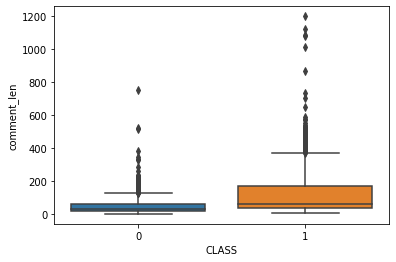

In [25]:
sb.boxplot(x='CLASS', y='comment_len', data=df)

In [26]:
spam_comments = df[df["CLASS"] == 1]["CONTENT"]
ham_comments = df[df["CLASS"] == 0]["CONTENT"]
all_comments = df["CONTENT"]

spam_words = ''
ham_words = ''
all_words = ''

"insert all available words in the column individually and count the most occuring word into an empty string"
for word in spam_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for word in ham_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

for word in all_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        all_words = all_words + words + ' '

In [27]:
spamcloud = WordCloud(width=300, height=300).generate_from_text(spam_words)
hamcloud = WordCloud(width=300, height=300).generate_from_text(ham_words)
allcloud = WordCloud(width=300, height=300).generate_from_text(all_words)

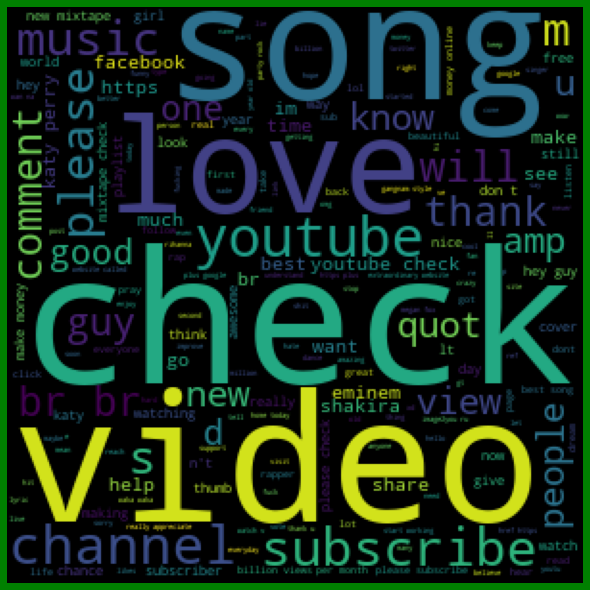

In [28]:
#All words in the dataset Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(allcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

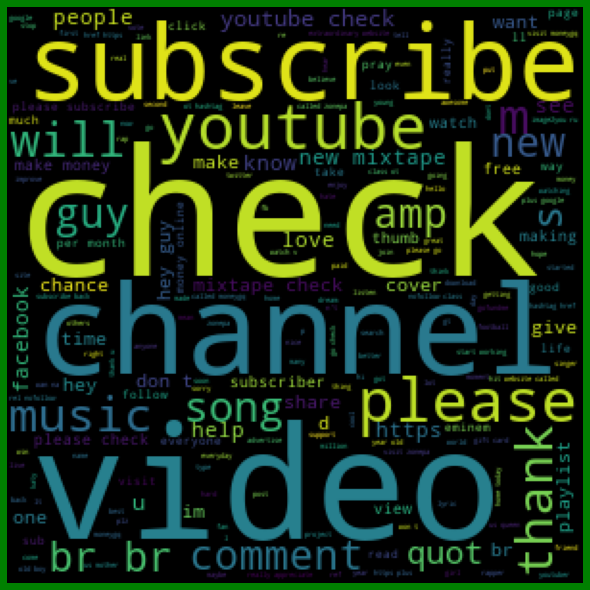

In [29]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(spamcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

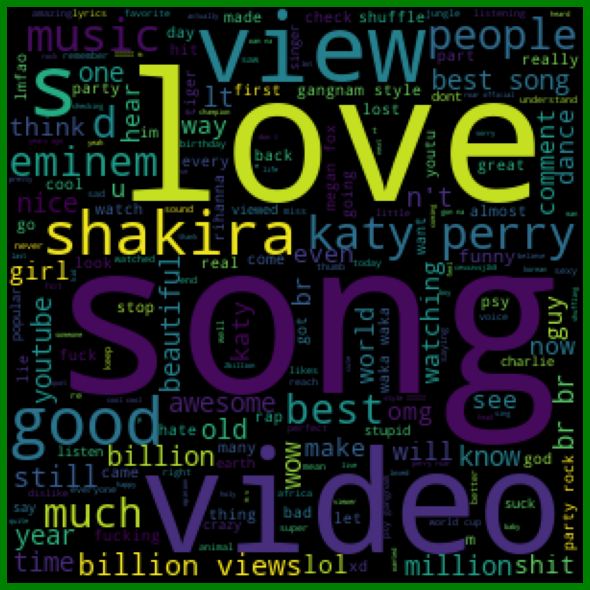

In [30]:
#Ham Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(hamcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

We can see from the wordcloud that words in spam comments consist lots words that doesn' relate to the video which in this case are music videos. The words that exist consist of lots of words such as 'check', 'subscribe', 'please', 'help', which are comments to lure people to check or subscribe to their channel which is clearly spam words. 

Looking at the word cloud for all words, we can see that the word 'check', 'subscribe', 'please' is one of the most populated words in the dataset. These frequent words can be an explaination for the variability in end spam classification. 

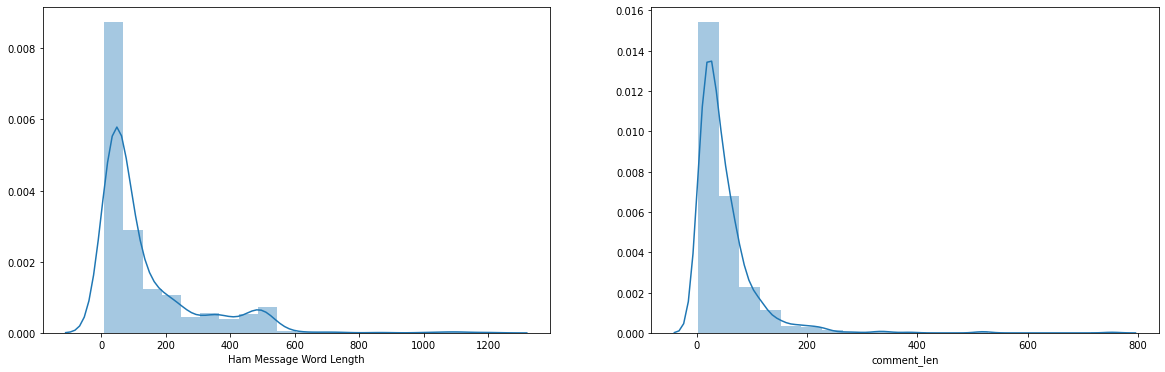

In [31]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sb.distplot(df[df["CLASS"] == 1]["comment_len"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Messages Word Length")

sb.distplot(df[df["CLASS"] == 0]["comment_len"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

In [32]:
df.comment_len.describe()

count    1956.000000
mean       94.700920
std       128.222062
min         2.000000
25%        29.000000
50%        48.000000
75%        97.000000
max      1200.000000
Name: comment_len, dtype: float64

In [33]:
# Let's see the longest message 1200
df[df['comment_len'] == 1200]['CONTENT'].iloc[0]

'&lt;script&gt;document.write(\'&lt;a target="_self" href=" http://rover.ebay.com/rover/1/710-53481-19255-0/1?icep_ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;ipn=psmain&amp;icep_vectorid=229508&amp;kwid=902099&amp;mtid=824&amp;kw=lg"&gt;check  this out new arive on ebay&lt;/a&gt;&lt;img  style="text-decoration:none;border:0;padding:0;margin:0;" src=" http://rover.ebay.com/roverimp/1/710-53481-19255-0/1?ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;mpt=\'+Math.floor(Math.random()*999999999)+\'"&gt;\');&lt;/script&gt;&lt;noscript&gt;&lt;a  target="_self" href=" http://rover.ebay.com/rover/1/710-53481-19255-0/1?icep_ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;ipn=psmain&amp;icep_vectorid=229508&amp;kwid=902099&amp;mtid=824&amp;kw=lg"&gt;check  this out new arive on ebay&lt;/a&gt;&lt;img  style="text-decoration:none;border:0;padding:0;ma

We only need data from Comment and Class column. So, we will drop the other columns that is not important in this project.

In [34]:
df = df.drop(['COMMENT_ID', 'AUTHOR', 'DATE', 'comment_len'], axis=1)

In [35]:
print(df.describe)

<bound method NDFrame.describe of                                                 CONTENT  CLASS
0     Huh, anyway check out this you[tube] channel: ...      1
1     Hey guys check out my new channel and our firs...      1
2                just for test I have to say murdev.com      1
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1
...                                                 ...    ...
1951  I love this song because we sing it at Camp al...      0
1952  I love this song for two reasons: 1.it is abou...      0
1953                                                wow      0
1954                            Shakira u are so wiredo      0
1955                         Shakira is the best dancer      0

[1956 rows x 2 columns]>


Lowercase all the words in the df column "CONTENT"

In [36]:
df["CONTENT"] = df["CONTENT"].str.lower()

Replace all the html tags <a... > with the keyword "htmllink"

In [37]:
df['CONTENT']=df['CONTENT'].str.replace("(<a.+>)","htmllink")

Remove all other html tags.

In [38]:
df['CONTENT']=df['CONTENT'].str.replace("(<.+>)","")

Replace all the strings starting with "http" or "https" with the keyword "htmllink"

In [39]:
df['CONTENT']=df['CONTENT'].str.replace(r'(https?://\S+|http?://\S+ )',"htmllink")

Replace all the strings containing ".com"  or "watch\"  with the keyword "htmllink"

In [40]:
df["CONTENT"]=df["CONTENT"].str.replace(r"\S*.com\S*|\S*watch\?\S*","htmllink")

In [41]:
def clean_nonalpha(input_text):
  pattern = re.compile('([^\s\w]|)+')
  return pattern.sub("",input_text)

In [42]:
def translate_emojis(input_text):
  return emoji.demojize(input_text, delimiters=(" ", " "))

In [43]:
def clean_only_numbers(input_text):
  return ' '.join(word for word in input_text.split() if not word.isdigit())

In [44]:
df["CONTENT"]=df["CONTENT"].apply(translate_emojis)

In [45]:
df["CONTENT"]=df["CONTENT"].apply(clean_nonalpha)

In [46]:
df["CONTENT"]=df["CONTENT"].apply(clean_only_numbers)

According to the paper, they achieved better results by not filtering stopwords and lemmatizing. This first approach is not going to perform further filtering.

Bag of words approach.

In [47]:
vocab = []
for sentence in df["CONTENT"]:
  for word in sentence.split():
    vocab.append(word)

In [48]:
# Eliminate duplicate words in the vocabulary
vocabulary = set(vocab)
print(len(vocabulary))

3849


In [49]:
for word in vocabulary:
  df[word] = 0

In [50]:
df.head()

,CONTENT,CLASS,current,possiblequot,survive,gtgtdont,famine,her,surviving,verses,...,boyi,model,popular,disappointed,sec,youtubeqq,costfree,too,freaking,proud
0,huh anyway check out this youtube channel koby...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hey guys check out my new channel and our firs...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,just for test i have to say htmllink,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,me shaking my sexy ass on my channel enjoy _,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,htmllink check this out,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
for index, sentence in enumerate(df["CONTENT"]):
  for word in sentence.split():
    df[word].iloc[index] += 1  


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
df.head()

,CONTENT,CLASS,current,possiblequot,survive,gtgtdont,famine,her,surviving,verses,...,boyi,model,popular,disappointed,sec,youtubeqq,costfree,too,freaking,proud
0,huh anyway check out this youtube channel koby...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hey guys check out my new channel and our firs...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,just for test i have to say htmllink,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,me shaking my sexy ass on my channel enjoy _,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,htmllink check this out,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can create two dictionaries, for spam and not spam comments, containing the words and the total count

In [53]:
df_spam =df[df["CLASS"] == 1]
df_spam.loc['Total']= df_spam.sum(numeric_only=True, axis=0)
df_spam.tail()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,CONTENT,CLASS,current,possiblequot,survive,gtgtdont,famine,her,surviving,verses,...,boyi,model,popular,disappointed,sec,youtubeqq,costfree,too,freaking,proud
1944,hey music fans i really appreciate all of you ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1945,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1946,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1947,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,NaN,1005.0,1.0,1.0,0.0,1.0,1.0,14.0,0.0,1.0,...,0.0,3.0,3.0,2.0,1.0,1.0,1.0,16.0,1.0,0.0


In [54]:
print(df_spam.shape)

(1006, 3851)


In [55]:
df_not_spam =df[df["CLASS"] == 0]
df_not_spam.loc['Total']= df_not_spam.sum(numeric_only=True, axis=0)
df_not_spam.tail()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,CONTENT,CLASS,current,possiblequot,survive,gtgtdont,famine,her,surviving,verses,...,boyi,model,popular,disappointed,sec,youtubeqq,costfree,too,freaking,proud
1952,i love this song for two reasons 1it is about ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,wow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,shakira u are so wiredo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955,shakira is the best dancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,NaN,0.0,0.0,0.0,2.0,0.0,0.0,33.0,1.0,2.0,...,1.0,0.0,8.0,0.0,1.0,0.0,0.0,6.0,1.0,1.0


In [56]:
print(df_not_spam.shape)

(952, 3851)


Drop the first two columns of each dictionary.

In [57]:
df_spam.drop("CONTENT",1,inplace=True)
df_spam.drop("CLASS",1,inplace=True)
df_not_spam.drop("CONTENT",1,inplace=True)
df_not_spam.drop("CLASS",1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [58]:
dict_spam = {word: count for word, count in zip(df_spam.columns,df_spam.loc['Total'])}
dict_not_spam = {word: count for word, count in zip(df_not_spam.columns,df_not_spam.loc['Total'])}

In [59]:
sorted_spam = sorted(dict_spam.items(),key=lambda x: x[1], reverse=True)
sorted_not_spam = sorted(dict_not_spam.items(),key=lambda x: x[1], reverse=True)
print(sorted_spam[:10])
print(sorted_not_spam[:10])

[('out', 569.0), ('check', 545.0), ('htmllink', 514.0), ('my', 512.0), ('and', 485.0), ('to', 480.0), ('you', 463.0), ('i', 457.0), ('the', 413.0), ('a', 389.0)]
[('this', 293.0), ('i', 284.0), ('the', 278.0), ('song', 217.0), ('is', 214.0), ('love', 144.0), ('to', 133.0), ('and', 132.0), ('a', 114.0), ('it', 112.0)]


In [60]:
X = df.iloc[:,2:]
y = df.iloc[:,1]
pd.crosstab(index=y,columns="Count")

col_0,Count
CLASS,
0,951
1,1005


## Data Model
For classification there are some famous classification algorithms and we are going to use the below classification algorithms with this data set and see their prediction results The Algorithms used below in this notebooks are :

- Multinomial Naive Bayes
- K-Nearest Neighbour
- Support Vector Machine 
- Gaussian Naive Bayes

We have chosen these classifier because they tend to have a decent performance for this type of dataset and typically do not need much setup.

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [62]:
from sklearn.svm import SVC #support vector classifier
clf = SVC(kernel='linear', random_state=0, gamma=0.001).fit(X_train, y_train)
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


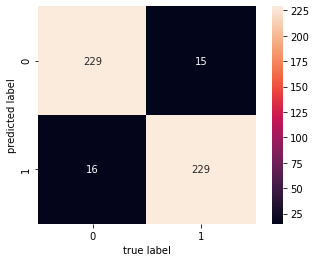

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       245
           1       0.93      0.94      0.94       244

    accuracy                           0.94       489
   macro avg       0.94      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489



Implementing Naive Bayes model on the train dataset classified with bag2words approach

We will use sklearns sklearn.naive_bayes method to make predictions on our dataset.

Specifically, we will be using the multinomial Naive Bayes. This particular classifier is suitable for classification with discrete features (such as in our case, word counts for text classification). It takes in integer word counts as its input.

the alpha parameter in MultinomialNB is set to 0.75 because the accuracy score is the best at this number as compared to the default value 1.0

In [65]:
# import and initialize a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.75)

In [66]:
#Train model
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.75, class_prior=None, fit_prior=True)

In [67]:
#Predict the outcome of either spam or ham
y_pred_NB = nb.predict(X_test)

In [68]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_NB)

0.8895705521472392

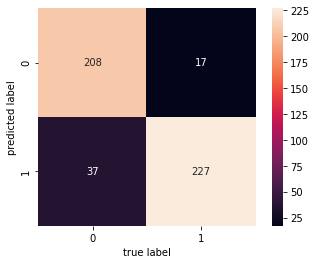

In [69]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_NB) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_NB, digits=4))

              precision    recall  f1-score   support

           0     0.9244    0.8490    0.8851       245
           1     0.8598    0.9303    0.8937       244

    accuracy                         0.8896       489
   macro avg     0.8921    0.8897    0.8894       489
weighted avg     0.8922    0.8896    0.8894       489



From the confusion matrix we see:

- There are 241 actual ham (class 0)
- There 248 actual spam (class 1)

Our Naive Bayes classifier more or less classified most of the actual ham messages. There are some ham classed as spam (false positives)- which is not that ideal for a spam classifier considering some of the ham messages will be identified as spam. The number of false positives altho quite low they (where spam is positive class) are not still ideal because some ham messages will be classified as spam.

When it comes to the actual spam messages, the classifier has correctly identified 220 spam messages, but it has also classified 28 spam as ham (false negatives), so it is most recipients are likely to be getting 1 unfiltered spam messages out of 10 filtered.

However for the classification report, the recall for ham is okay-ish but we are pulling in some spam messages as well (precision = 0.90)

The classifier's ability to find all the spam messages is better at recall = 0.90, altho some ham messages will still be pulled in with the precision = 0.89

Implementing KNN model on the train dataset classified with bag2words approach

Feature Scaling

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

Training and Predictions

In [72]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train_scaler, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [73]:
y_pred_knn = classifier.predict(X_test_scaler)

Evaluating the Algorithm

In [74]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[237   8]
 [ 57 187]]
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       245
           1       0.96      0.77      0.85       244

    accuracy                           0.87       489
   macro avg       0.88      0.87      0.87       489
weighted avg       0.88      0.87      0.87       489



Comparing Error Rate with the K Value

In [75]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

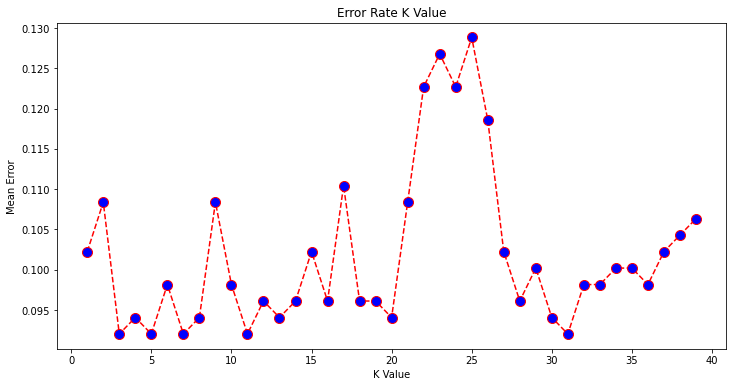

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

 The mean error is low when the value of the K is 5 and 9

Implementing Gaussian model on the train dataset classified with bag2words approach

Here we will be using Gaussian Naive Bayes (GNB) classification on the word counts. Compared to multinomial naive bayes classification, it is likely that we will find the accuracy for spam classification worse as GNB is better suited for continuous data as it assumes that the input data has a Gaussian(normal) distribution.

In [77]:
from sklearn.naive_bayes import GaussianNB
#initialize 
gb = GaussianNB()
print(gb)

#train model
gb.fit(X_train, y_train)

#Predict the outcome of either spam or ham
y_pred_gb = gb.predict(X_test)

# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_gb)

GaussianNB(priors=None, var_smoothing=1e-09)


0.7648261758691206

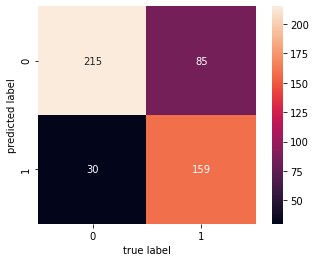

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_gb) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [79]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       245
           1       0.84      0.65      0.73       244

    accuracy                           0.76       489
   macro avg       0.78      0.76      0.76       489
weighted avg       0.78      0.76      0.76       489



Implementing simple svm linear model on the train dataset classified with bag2words approach

In [80]:
sig = SVC(kernel='sigmoid', random_state=0, gamma=0.001).fit(X_train, y_train)
print(sig)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


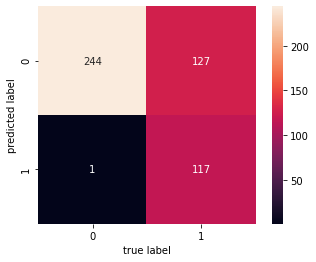

In [81]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_sig = sig.predict(X_test)
mat = confusion_matrix(y_test, y_pred_sig) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [82]:
print(classification_report(y_test, y_pred_sig))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       245
           1       0.99      0.48      0.65       244

    accuracy                           0.74       489
   macro avg       0.82      0.74      0.72       489
weighted avg       0.82      0.74      0.72       489



### Compare accuracy score to the other classifier

In [83]:
from sklearn.metrics import accuracy_score
print('Accuracy score for linear kernel: {}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score for multinomial naive bayes: {}'.format(accuracy_score(y_test, y_pred_NB)))
print('Accuracy score for KNN: {}'.format(accuracy_score(y_test, y_pred_knn)))
print('Accuracy score for gaussian naive bayes: {}'.format(accuracy_score(y_test, y_pred_gb)))
print('Accuracy score for sigmoid kernel: {}'.format(accuracy_score(y_test, y_pred_sig )))

Accuracy score for linear kernel: 0.9366053169734151
Accuracy score for multinomial naive bayes: 0.8895705521472392
Accuracy score for KNN: 0.8670756646216768
Accuracy score for gaussian naive bayes: 0.7648261758691206
Accuracy score for sigmoid kernel: 0.7382413087934561


We can see the Naive Bayes have the best score over other classification algorithms. Its ability to handle an extremely large number of features which is in our case, each word is treated as a feature and there are thousands of different words. Also, it performs well even with the presence of irrelevant features and is relatively unaffected by them as we can see by removing emojis from the comments. Also tuning the parameters for Naive Bayes' are not really necessary except when distribution of data is well known.

# **Word2Vec Model**

In [84]:
#pip install --upgrade gensim

In [117]:
import spacy
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [118]:
df.to_csv("clean_comments.csv")
!python -m spacy download en

Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 163, in _run_module_as_main
    mod_name, _Error)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 111, in _get_module_details
    __import__(mod_name)  # Do not catch exceptions initializing package
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/__init__.py", line 12, in <module>
    from . import pipeline
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/pipeline/__init__.py", line 4, in <module>
    from .pipes import Tagger, DependencyParser, EntityRecognizer, EntityLinker
  File "pipes.pyx", line 25, in init spacy.pipeline.pipes
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/pipeline/functions.py", line 4, in <module>
    from ..language import component
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/language

 # Visualising using PCA

In [120]:
std = StandardScaler().fit_transform(df.drop(["CONTENT"], axis = 1)) 
X_scaled_df = pd.DataFrame(std)
pca = PCA(n_components=1956)
principalComponents = pca.fit_transform(std)

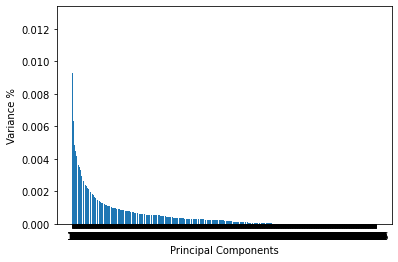

In [121]:
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_,)
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

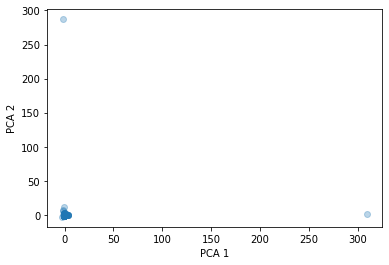

In [122]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [87]:
class W2V_embedding:
  def __init__(self, document, lemma, stopwords, min_count, window, nlp):
    self.document = document
    self.nlp = nlp
    self.lemma = lemma
    self.stopwords = stopwords
    self.min_count = min_count
    self.window = window
  def clean_sentence(self, sentence):
    # Lemmatizes and removes stopwords
    if self.lemma and self.stopwords:
      txt = [token.lemma_ for token in sentence if not token.is_stop]
    elif self.lemma:
      txt = [token.lemma_ for token in sentence ]
    elif self.stopwords:
      txt = [token for token in sentence if not token.is_stop]
    return ' '.join(txt)
  def clean_document(self):
    #Clean and drop duplicates from the comments in the dataset.
    txt = [self.clean_sentence(sentence) for sentence in self.nlp.pipe(self.document, batch_size=500, n_threads=-1)]
    df_clean = pd.DataFrame({'clean': txt})
    df_clean = df_clean.dropna().drop_duplicates()
    sentences = [row.split() for row in df_clean['clean']]
    return sentences
  def run(self):
    self.sentences = self.clean_document()
    cores = multiprocessing.cpu_count() 
    w2v_model = Word2Vec(min_count=self.min_count,
                     window=self.window,
                     size=300,
                     workers=cores-1)
    w2v_model.build_vocab(self.sentences, progress_per=100)
    w2v_model.train(self.sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)
    w2v_model.init_sims(replace=True)
    return w2v_model


In [88]:
nlp = spacy.load('en', disable=['ner','parser'])
init_w2v = W2V_embedding(min_count=1, window=5, lemma=True, stopwords=True, document=df["CONTENT"], nlp=nlp)
w2v_model = init_w2v.run()

In [89]:
w2v_model.wv.most_similar(positive=["like"])

[('second', 0.975615382194519),
 ('kitten', 0.9630234837532043),
 ('let', 0.9555834531784058),
 ('think', 0.9532767534255981),
 ('d', 0.9510558247566223),
 ('you39re', 0.9488463401794434),
 ('people', 0.9420385360717773),
 ('miss', 0.9417939782142639),
 ('not', 0.9387949705123901),
 ('loose', 0.9377699494361877)]

In [90]:
comments_array = np.zeros(shape=(len(df["CONTENT"]),300))
for index, sentence in enumerate(df["CONTENT"]):
  tokens = nlp(sentence)
  clean_sentence = [token.lemma_ for token in tokens if not token.is_stop]
  #clean_sentence = [str(token) for token in tokens ]
  sentence_vector = []
  for word in clean_sentence: # In the case a word is not found in the vocabulary, we will append a vector of zeros instead
    try: 
      sentence_vector.append(w2v_model[word] ) 
    except:
      sentence_vector.append(np.zeros(300))
      print(word, 'not found')
  comments_array[index] = np.mean(sentence_vector,axis=0)

<ipython-input-90-09fbaba9c113>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sentence_vector.append(w2v_model[word] )
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [91]:
X = comments_array
isnan = np.argwhere(np.isnan(X))
nan_comments = sorted(set(isnan[:,0])) #index of comments that are NaN values

In [92]:
X[nan_comments,:] = np.zeros(300) # translating NaN comments to an array of zeroes
y = df.iloc[:,1]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
clf = SVC(kernel='linear', random_state=0, gamma=0.001).fit(X_train, y_train)
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


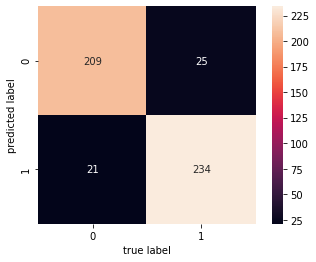

In [94]:
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [95]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       230
           1       0.92      0.90      0.91       259

    accuracy                           0.91       489
   macro avg       0.91      0.91      0.91       489
weighted avg       0.91      0.91      0.91       489



Implementing Naive Bayes model on the train dataset classified with Word2vec approach

In [96]:
# import and initialize a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb2 = MultinomialNB(alpha=0.75)

#checking the range of the numpy array 
r = np.ptp(X_train,axis=1)
print(X_train)
print(r)
print("range of numpy array :", max(r), min(r))

[[ 0.01164836 -0.05515609  0.00341941 ... -0.09232707  0.08940629
  -0.02354774]
 [-0.00986564 -0.03904142 -0.06008878 ... -0.12426916  0.09646945
   0.00890814]
 [ 0.03810503 -0.08131605 -0.050923   ... -0.109651    0.107363
  -0.00498348]
 ...
 [ 0.05403807 -0.08884452 -0.04566212 ... -0.11885785  0.11837731
   0.00017525]
 [ 0.03695291 -0.06505718 -0.0068187  ... -0.07662397  0.08208536
  -0.02449102]
 [ 0.03862805 -0.06675083 -0.03649784 ... -0.07268029  0.08532887
  -0.01300035]]
[0.27641669 0.34207061 0.31183353 ... 0.32078375 0.32158408 0.2731107 ]
range of numpy array : 0.38256698846817017 0.0


In [97]:
from sklearn.preprocessing import MinMaxScaler
#Normalizing the values in the array because naive bayes doesn't work with negative values
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)

In [98]:
#Train model
nb2.fit(X_train_minmax, y_train)

MultinomialNB(alpha=0.75, class_prior=None, fit_prior=True)

In [99]:
#Predict the outcome of either spam or ham
y_pred_NB2 = nb2.predict(X_test)

In [100]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_NB2)

0.8507157464212679

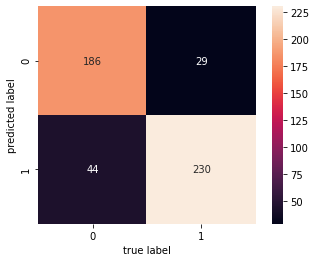

In [101]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_NB2) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_NB2, digits=4))

              precision    recall  f1-score   support

           0     0.8651    0.8087    0.8360       230
           1     0.8394    0.8880    0.8630       259

    accuracy                         0.8507       489
   macro avg     0.8523    0.8484    0.8495       489
weighted avg     0.8515    0.8507    0.8503       489



K-nearest Neighbor

Feature Scaling

In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

Training and Predictions

In [104]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train_scaler, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [105]:
y_pred_knn2 = classifier.predict(X_test_scaler)

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_knn2))
print(classification_report(y_test, y_pred_knn2))

[[216  14]
 [ 35 224]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       230
           1       0.94      0.86      0.90       259

    accuracy                           0.90       489
   macro avg       0.90      0.90      0.90       489
weighted avg       0.90      0.90      0.90       489



Comparing Error Rate with the K Value

In [107]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaler, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

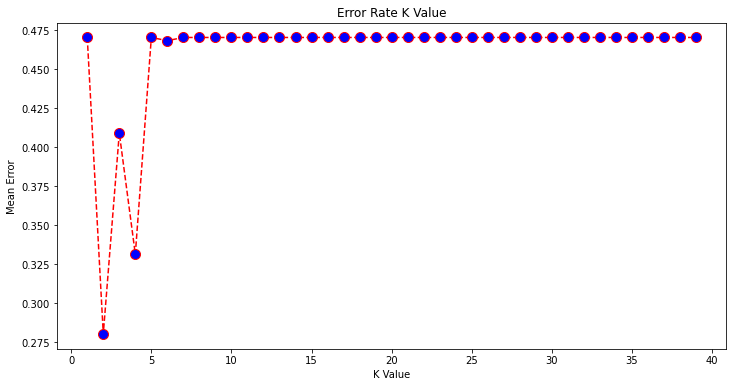

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Best K value is probably between 3 and 5 as can be seen from the error rate k value

Implementing Gaussian model on the train dataset classified with word2vec approach

In [109]:
from sklearn.naive_bayes import GaussianNB
#initialize 
gb = GaussianNB()

#train model
gb.fit(X_train, y_train)

#Predict the outcome of either spam or ham
y_pred_gb2 = gb.predict(X_test)

# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_gb2)

0.885480572597137

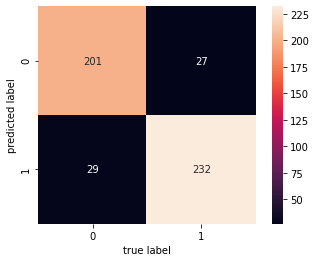

In [110]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_gb2) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [111]:
print(classification_report(y_test, y_pred_gb2))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       230
           1       0.89      0.90      0.89       259

    accuracy                           0.89       489
   macro avg       0.89      0.88      0.89       489
weighted avg       0.89      0.89      0.89       489



Implementing simple svm linear model on the train dataset classified with word2vec approach

In [112]:
sig = SVC(kernel='sigmoid', random_state=0, gamma=0.001).fit(X_train, y_train)
print(sig)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


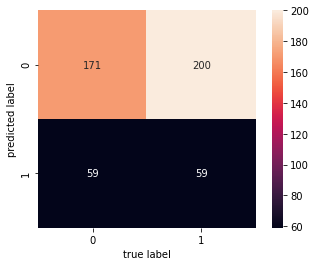

In [113]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_sig2 = sig.predict(X_test)
mat = confusion_matrix(y_test, y_pred_sig) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [114]:
print(classification_report(y_test, y_pred_sig2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.53      1.00      0.69       259

    accuracy                           0.53       489
   macro avg       0.26      0.50      0.35       489
weighted avg       0.28      0.53      0.37       489



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Comparing accuracy score to other classifier

In [115]:
from sklearn.metrics import accuracy_score
print('Accuracy score for linear kernel: {}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score for multinomial naive bayes: {}'.format(accuracy_score(y_test, y_pred_NB2)))
print('Accuracy score for KNN: {}'.format(accuracy_score(y_test, y_pred_knn2)))
print('Accuracy score for gaussian naive bayes: {}'.format(accuracy_score(y_test, y_pred_gb2)))
print('Accuracy score for sigmoid kernel: {}'.format(accuracy_score(y_test, y_pred_sig2)))

Accuracy score for linear kernel: 0.9059304703476483
Accuracy score for multinomial naive bayes: 0.8507157464212679
Accuracy score for KNN: 0.8997955010224948
Accuracy score for gaussian naive bayes: 0.885480572597137
Accuracy score for sigmoid kernel: 0.5296523517382413
